In [2]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.cluster import KMeans

#others
from xgboost import XGBRegressor
from xgboost import plot_tree
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import time
import xarray as xr
import sherpa
import time
from scipy.spatial import Delaunay
from scipy import interpolate
from copy import deepcopy

# enable autoreload
%load_ext autoreload
%autoreload 2
# Variables from config file
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES
from math import pi as PI

In [5]:
# Split the stations by the number of samples available
columns = deepcopy(LABELS)
columns.extend(["season_wet", "elevation", "lat", "lon"])
for item in columns:
    print(item, end=' ')

# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_combined = pd.concat([df_train, df_valid, df_test])

air2m air1000_500 hgt500 hgt1000 omega500 pottemp1000-500 pottemp1000-850 pr_wtr shum-uwnd-700 shum-uwnd-925 shum-vwnd-700 shum-vwnd-950 shum700 shum925 skt slp season_wet elevation lat lon 

In [6]:
if False: # no need to run this cell
    df_original = pd.read_excel(f"{BASE_DIR}/FilledDataset2012.xlsx", sheet_name="Source")
    X = []
    for index, row in df_original.iterrows():
        if row.Year < 1948:
            # No need to keep data older than 1948 becase no data exists in netCDF files
            continue
        for i, cell in enumerate(row[2:]):
            X.append([row.SKN, row.Year, i + 1, cell])
    df_nonan = pd.DataFrame(X, columns=['skn', 'year', 'month', 'method']).dropna()

    valid_method = [
        'State/NCDC', 'State', 'NCDC', 'RAWS', 'Hydronet', 'SCAN', 'USGS',
        'Hydronet/NCDC', 'HaleNet', 'HC&S', 'AlanMair', 'AlanMair/State',
        'USGS/State', 'USGS/NCDC'
    ]
    df_valid_method = pd.DataFrame({"method": valid_method})
    df_valid_method = df_nonan.merge(right=df_valid_method, left_on='method', right_on='method')

    # inner join with valid method
    df_data_valid = df_combined.merge(right=df_valid_method, left_on=["skn", "year", "month"], right_on=['skn', 'year', 'month'])

    df_data_valid.to_csv(f"{BASE_DIR}/nonfilled_dataset.csv", index=False)

<hr>

In [3]:
df_load = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv")

In [4]:
# inner join with valid station (more than 300 stations)
threshold = 300
df_skn = df_load.groupby('skn').size().reset_index().rename(columns={0: "n_samples"})
df_skn_valid = df_skn[df_skn['n_samples'] > threshold]

df_data = df_load.merge(right=df_skn_valid, left_on='skn', right_on='skn')

In [5]:
df_train = df_data[df_data['year'] <= 2007]
df_test = df_data[df_data['year'] > 2007]

In [14]:
# linear regression
df_result_linear = []
for name, group in df_data.groupby(by='skn'):
    group.sort_values(by=['year', 'month'], inplace=True)
    
    X = np.array(group[columns])
    Y = np.array(group['data_in'])
    
    model = LinearRegression()
    
    yhat = cross_val_predict(model, X, Y, n_jobs=-1)
    df_result_linear.append(pd.DataFrame({"skn": [name] * group.shape[0], "data_in": Y, "pred": yhat}))
df_result_linear = pd.concat(df_result_linear)    

In [15]:
mean_squared_error(df_result_linear['data_in'], df_result_linear['pred'], squared=False)

3.5282127272604025

In [16]:
df_rmse_per_station = (
    df_result_linear.groupby('skn')
    .apply(
        lambda group: mean_squared_error(group['data_in'], group['pred'], squared=False)
    )
    .reset_index()
    .rename(columns={0: "rmse"})
)


In [24]:
params = {'n_estimators': 260, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 8, 'verbosity': 0}
n_stations = df_data.groupby('skn').size().shape[0]
df_result_xgb = []
for i, (name, group) in enumerate(df_data.groupby(by='skn')):
    
    group.sort_values(by=['year', 'month'], inplace=True)
    
    X = np.array(group[columns])
    Y = np.array(group['data_in'])
    
    model = XGBRegressor(**params)
    yhat = cross_val_predict(model, X, Y, n_jobs=-1)
    
    df_result_xgb.append(pd.DataFrame({"skn": [name] * group.shape[0], "data_in": Y, "pred": yhat}))
    print(f"{i}/{n_stations}",end='\r')

df_result_xgb = pd.concat(df_result_xgb)

In [32]:
df_result_linear.to_csv(f"{BASE_DIR}/realdata/result_linear.csv", index=False)
df_result_xgb.to_csv(f"{BASE_DIR}/realdata/result_xgb.csv", index=False)

<hr>

In [41]:
df_result_xgb = pd.read_csv(f"{BASE_DIR}/realdata/result_xgb.csv")
df_resilt_linear =  pd.read_csv(f"{BASE_DIR}/realdata/result_linear.csv")

In [44]:
rmse_linear = mean_squared_error(df_result_linear['data_in'], df_result_linear['pred'], squared=False)
rmse_xgb = mean_squared_error(df_result_xgb['data_in'], df_result_xgb['pred'], squared=False)

print("RMSE on linear regression:{:.3f}\nRMSE on xgb:{:.3f}".format(rmse_linear, rmse_xgb))

RMSE on linear regression:3.528
RMSE on xgb:3.805


In [50]:
df_rmse_per_station_linear = (
    df_result_linear.groupby('skn')
    .apply(
        lambda group: mean_squared_error(group['data_in'], group['pred'], squared=False)
    ).reset_index()
    .rename(columns={0 : "rmse"})
)

df_rmse_per_station_xgb = (
    df_result_xgb.groupby('skn')
    .apply(
        lambda group: mean_squared_error(group['data_in'], group['pred'], squared=False)
    ).reset_index()
    .rename(columns={0: "rmse"})
)

<hr>

In [83]:
columns

['air2m',
 'air1000_500',
 'hgt500',
 'hgt1000',
 'omega500',
 'pottemp1000-500',
 'pottemp1000-850',
 'pr_wtr',
 'shum-uwnd-700',
 'shum-uwnd-925',
 'shum-vwnd-700',
 'shum-vwnd-950',
 'shum700',
 'shum925',
 'skt',
 'slp',
 'season_wet',
 'elevation',
 'lat',
 'lon']

Text(0.5, 0, 'air1000_500')

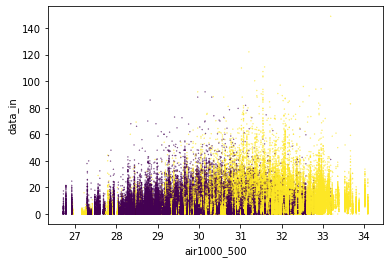

In [90]:
label = columns[1]
fig, ax = plt.subplots(1)
ax.scatter(df_load[label], df_load['data_in'],  s=0.1, c=df_load['season_wet'])
ax.set_ylabel('data_in')
ax.set_xlabel(label)

In [93]:
model = RandomForestRegressor(n_jobs=-1, verbose=1)
X = np.array(df_load[columns])
Y = np.array(df_load['data_in'])
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2)
model.fit(Xtrain, Ytrain)
yhat = model.predict(Xtest)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished


In [94]:
mean_squared_error(Ytest, yhat, squared=False)

2.340185220334378

ImportError: You must install graphviz to plot tree

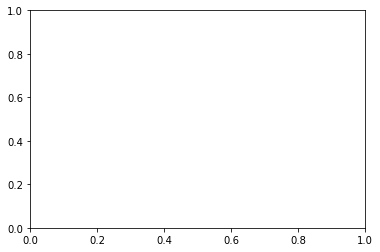

In [144]:
skn = df_data['skn'].sample().values[0]

X = np.array(df_data[df_data['skn'] == skn][columns])
Y = np.array(df_data[df_data['skn'] == skn]['data_in'])

#model = RandomForestRegressor(n_jobs=-1, verbose=0)
if True:
    params = {'n_estimators': 260, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 8, 'verbosity': 0}
    model = XGBRegressor(**params)

    yhat = cross_val_predict(model, X, Y, n_jobs=-1)
    plot_tree(model)
    print(mean_squared_error(Y, yhat, squared=False))
if False:
    params = {'n_estimators': 260, 'learning_rate': 0.1, 'max_depth': 3, 'early_stopping_rounds': 8, 'verbosity': 0}
    model = XGBRegressor(**params)
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.1, shuffle=False)
    model.fit(Xtrain, Ytrain, eval_metric='rmse')
    yhat = model.predict(Xtest)
    print("xgb, train", mean_squared_error(Ytrain, model.predict(Xtrain), squared=False))
    print("xgb, test", mean_squared_error(Ytest, yhat, squared=False))
    
    model = LinearRegression()
    model.fit(Xtrain, Ytrain)
    yhat = model.predict(Xtest)
    print("linear, train", mean_squared_error(Ytrain, model.predict(Xtrain), squared=False))
    print("linear, test", mean_squared_error(Ytest, yhat, squared=False))
    

In [130]:
df_rmse_per_station_linear[df_rmse_per_station['skn'] == skn]

,skn,rmse
249,500.0,1.780917


In [105]:
df_data['skn']

0           6.0
1           6.0
2           6.0
3           6.0
4           6.0
          ...  
244231    800.3
244232    800.3
244233    800.3
244234    800.3
244235    800.3
Name: skn, Length: 244236, dtype: float64